### 손글씨 데이터셋 (MNIST)을 활용한 분류모델

In [1]:
# 기본 라이브러리 불러오기
import numpy as np                     # 수치 연산
import pandas as pd                    # DataFrame 처리
import matplotlib.pyplot as plt        # 시각화 (그래프)
import seaborn as sns                  # 시각화 (차트)

# torch 계열 라이브러리
import torch                           # Pytorch 핵심 패키지
import torch.nn as nn                  # 신경망 레이어/모듈
import torch.nn.functional as F        # 활성화/손실 함수 등 함수 API
import torch.optim as optim            # 최적화함수 Optimizer

# 데이터셋 및 전처리
from torchvision import datasets, transforms  # 기본 데이터셋 로딩, 데이터셋 전처리

# 검증
from sklearn.metrics import confusion_matrix  # 혼동행렬 계산

- MNIST (손글씨 숫자 이미지) 데이터셋 다운로드 및 전처리

In [2]:
# 학습용 (MNIST Train) 데이터셋
train = datasets.MNIST(                 # MNIST 학습 데이터셋 객체 생성
    './data',                           # 데이터 저장 경로
    train=True,                         # 학습(train) 데이터셋 사용
    download=True,                      # 없으면 인터넷에서 다운로드
    transform = transforms.Compose([    # 전처리를 순서대로 적용 (전처리 파이프라인)
        transforms.ToTensor()           # PIL/ndarray -> torch.Tensor(0~1 스케일)
    ])
)

# 테스트용 (MNIST Test) 데이터셋
test = datasets.MNIST(
    './data',
    train=False,                        # 테스트(Test) 데이터셋 사용
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)

train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [3]:
img, label = train[0]    # 0번째 샘플에서 (이미지 텐서, 정답 라벨) 추출
img.shape                # 이미지 텐서 모양 확인 (1, 28, 28) : (채널, 높이, 너비)

torch.Size([1, 28, 28])

- Pytorch(MNIST) / Conv : channel-first (C, H, W)  
- Numpy / OpenCV / matplotlib / Tensorflow : channel-last (H, W, C)

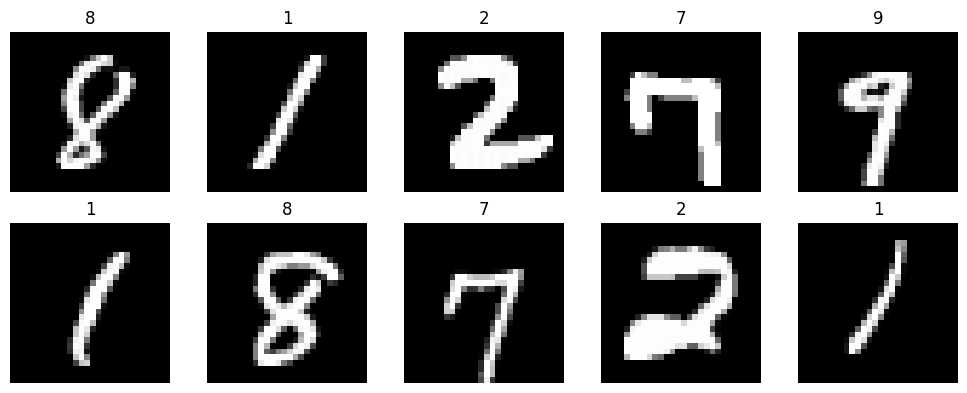

In [4]:
# 학습데이터 랜덤으로 10장 확인
idxs = np.random.choice(len(train), size=10, replace=False)  # 전체 중 랜덤 10개 인덱스

plt.figure(figsize=(10, 4))
for i, idx in enumerate(idxs):
    img, label = train[idx]      # 랜덤 샘플 (이미지 텐서, 라벨)  
    plt.subplot(2, 5, i + 1)     # 2행 5열
    plt.imshow(img.squeeze(0), cmap='gray')   # (1, 28, 28) -> (28, 28)
    plt.title(label)
    plt.axis("off")              # 축 제거

plt.tight_layout()
plt.show()

plt.imshow() 에서 받는 형태  
흑백 : (H, W)  
컬러 : (H, W, C)  
컬러 이미지의 경우 Pytorch 데이터셋이 (C, H, W) 형태라면 imshow()로 출력하기 위해서는 (H, W, C) 형태로 맞춰줘야 한다.

``` python
img_hwc = img.permute(1, 2, 0)    # (C, H, W) -> (H, W, C)
plt.imshow(img_hwc)
```


- MNIST 입력 / 정답 텐서 전처리 및 차원 확인

In [5]:
# 이미지 정규화 및 실수형 변환
x = train.data.float() / 255.  # RGB값 (0~255) -> 0~1로 스케일링
y = train.targets              # 각 이미지 정답 라벨 (텐서)

print(x.size())

# 입력 텐서 형태 변환
x = x.view(x.size(0), -1)      # (N, 28, 28) -> (N, 784)로 펼쳐짐(flatten)

print(x.shape, y.shape)        # x : (N, 784), y : (샘플수, )

torch.Size([60000, 28, 28])
torch.Size([60000, 784]) torch.Size([60000])


In [6]:
# 입력/출력 차원 정의
input_size = x.size(-1)          # 입력 특성 수 (784)
output_size = int(max(y)) + 1    # 라벨 최대값 + 1 = 클래스 갯수 10

print(f"input size : {input_size}, output_size = {output_size}")

input size : 784, output_size = 10


- 학습 / 검증 / 테스트 데이터셋 분리 및 정규화

In [7]:
# 학습/검증 데이터셋 비율 설정 및 개수 계산
ratios = [.8, .2]                              # Train / Valid 비율 (80%:20%)

train_cnt = int(x.size(0) * ratios[0])         # 전체 샘플 중 학습 샘플 수
valid_cnt = int(x.size(0) * ratios[1])         # 전체 샘플 중 검증 샘플 수
test_cnt = len(test.data)                      # 테스트 샘플 수
cnts = [train_cnt, valid_cnt]                  # split에 사용할 [train, valid] 크기

print(f"Train_cnt = {train_cnt}, valid_cnt = {valid_cnt}, test_cnt = {test_cnt}")

Train_cnt = 48000, valid_cnt = 12000, test_cnt = 10000


In [8]:
# 학습/검증 데이터셋 무작위 셔플 및 분할
indices = torch.randperm(x.size(0))  # 0 ~ N-1 인덱스 랜덤 순서로 생성

x = torch.index_select(x, dim=0, index=indices)    # 랜덤 index 순서로 x를 재정렬
y = torch.index_select(y, dim=0, index=indices)    # 랜덤 index 순서로 y를 재정렬

x = list(x.split(cnts, dim=0))    # x를 train/valid 크기로 나눠 리스트로 반환
y = list(y.split(cnts, dim=0))    # y를 train/valid 크기로 나눠 리스트로 반환

In [9]:
# 테스트데이터 정규화 및 추가
x += [(test.data.float() / 255.).view(test_cnt, -1)]  # 테스트 x를 0~1로 정규화 후 (N, 784)로 펼쳐 추가
y += [test.targets]                                   # y도 list로 추가

# 최종 데이터셋 크기 출력
for x_i, y_i in zip(x, y):             # (train, valid, test) 순서로 순회
    print(x_i.size(), y_i.size())      # 각 데이터셋의 입력/라벨 텐서 크기 출력

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [10]:
class Block(nn.Module):

    # 입력 -> 선형변환 -> 활성화 -> (BatchNorm or Dropout)으로 구성된 블록을 초기화하는 생성자
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4):
        self.input_size = input_size              # 입력 차원 저장
        self.output_size = output_size            # 출력 차원 저장
        self.use_batch_norm = use_batch_norm      # BN 사용 여부 저장
        self.dropout_p = dropout_p                # Dropout 비율 저장

        super().__init__()                        # nn.Module 초기화

        # BN을 사용할지, Dropout을 사용할지 선택해서 정규화 모듈을 반환하는 함수
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)  # BN 또는 Dropout 선택
        
        self.block = nn.Sequential(                        # 레이어들을 순서대로 묶어 하나의 블록으로 구성
            nn.Linear(input_size, output_size),            # input_size -> output_size 선형 변환
            nn.LeakyReLU(),                                # 음수 영역도 기울기 유지하는 활성화 함수
            get_regularizer(use_batch_norm, output_size)   # BatchNorm1d(output_size) 또는 Dropout(dropout_p)
        )

    # 입력 x를 block을 통과시켜 출력 y를 만드는 순전파
    def forward(self, x):
        # |x| = (batch_size, input_size)    # 텐서의 모양 약속/설명
        y = self.block(x)                   # Linear -> LeakyReLU -> (BN/Dropout) 적용 
        # |y| = (batch_size, output_size)   # 텐서의 모양 약속/설명

        return y

In [11]:
class MyModel(nn.Module):

    # 여러 개의 Block을 쌓아 분류용 MLP (출력층 LogSoftmax 활성화함수)을 구성한다.
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4):
        super().__init__()               # nn.Module 초기화

        self.layers = nn.Sequential(     # 레이어들을 순서대로 묶어 모델 구성
            Block(input_size, 500, use_batch_norm, dropout_p),   # 입력 차원 -> 500 차원 블록
            Block(500, 400, use_batch_norm, dropout_p),          # 500 -> 400 차원(노드) 블록
            Block(400, 300, use_batch_norm, dropout_p),          # 400 -> 300 차원(노드) 블록
            Block(300, 200, use_batch_norm, dropout_p),          # 300 -> 200 차원(노드) 블록
            Block(200, 100, use_batch_norm, dropout_p),          # 200 -> 100 차원(노드) 블록
            nn.Linear(100, output_size),                         # 마지막 은닉(100) -> 출력(output_size) 선형 변환
            nn.LogSoftmax(dim=1)                                 # 클래스 차원 (dim-1) 기준 log-확률로 변환
        )

    # 입력 x를 순차 레이어(self.layers)에 통과시켜 최종 출력 y를 만드는 순전파
    def forward(self, x):
        # |x| = (batch_size, input_size)    # 텐서의 모양 약속/설명
        y = self.layers(x)                  # Block들 -> Linear -> LogSoftmax 순서로 통과
        # |y| = (batch_size, output_size)   # 텐서의 모양 약속/설명

        return y  # 각 클래스별 log-확률로 변환

In [12]:
model = MyModel(
    input_size,              # 입력 벡터 차원 (784)
    output_size,             # 출력 벡터 차원 (10)
    use_batch_norm=True      # 각 Block에서 BatchNorm 사용 (Dropout은 사용하지 않음)
)

model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [13]:
# 손실함수 : NLLLoss (음의 로그 우도 손실) = LogSoftmax 출력(log-확률)과 함께 사용한다.
crit = nn.NLLLoss()

In [14]:
optimizer = optim.Adam(    # lr 기본값 0.001 사용한 Adam Optimizer
    model.parameters()     # 학습 대상 파라미터 (가중치/편향) 전달
) 

In [15]:
# 만약 GPU 사용가능시 "cuda"로, 불가시 "cpu" (삼항연산자)
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [16]:
# 모델과 데이터셋을 선택된 장치(GPU or CPU)로 이동시키기
model = model.to(device)  # 모델 파라미터를 device(cuda/cpu)로 이동

x = [x_i.to(device) for x_i in x]  # (train/valid/test) 입력 텐서들을 device로 이동
y = [y_i.to(device) for y_i in y]  # (train/valid/test) 라벨 텐서들을 device로 이동

In [17]:
# 학습 하이퍼파라미터 설정
n_epochs = 1000         # 학습 반복
batch_size = 256        # 미니배치 크기 (한번에 학습할 샘플 수)
print_interval = 10     # 로그 출력 주기

In [18]:
# Early Stopping 설정
from copy import deepcopy    # 객체(모델 파라미터) 복사 유틸

lowest_loss = np.inf         # 검증 손실 최소값
best_model = None            # 최고 성능 모델

early_stop = 50              # 개선이 없을 시 중단할 patience (기다림 횟수)
lowest_epoch = np.inf        # 최솟값 갱신된 epoch

In [19]:
y[0].size()

torch.Size([48000])

In [20]:
# 학습 루프 + 검증 + Early Stopping

# 손실 기록 리스트 초기화
train_history, valid_history = [], []    # epoch별 train/valid loss 저장 리스트

# 에폭 반복
for i in range(n_epochs):
    model.train()        # 학습모드 (Dropout/BN 등 활성화)

    # 학습 데이터 셔플 및 미니배치 분할
    indices = torch.randperm(x[0].size(0)).to(device)      # 학습 데이터 인덱스 랜덤 셔플
    x_ = torch.index_select(x[0], dim=0, index=indices)    # 셔플된 순서로 train x 재정렬
    y_ = torch.index_select(y[0], dim=0, index=indices)    # 셔플된 순서로 train y 재정렬

    x_ = x_.split(batch_size, dim=0)   # 미니배치 단위로 분할 (튜플 반환) 
    y_ = y_.split(batch_size, dim=0)   # 미니배치 단위로 분할 (튜플 반환) 

    train_loss, valid_loss = 0, 0      # epoch 누적 손실 평균
    y_hat = []                         # 검증 예측값 저장

    # 미니배치 단위로 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)                  # 순전파 : logits 계산
        loss = crit(y_hat_i, y_i.squeeze())   # 손실 계산 (shape은 (N, )형태로 변환)

        optimizer.zero_grad()                 # 이전 배치 기울기 초기화
        loss.backward()                       # 역전파 : 기울기 계산

        optimizer.step()                      # 파라미터 업데이트
        train_loss += float(loss)             # 텐서 -> 파이썬 float로 누적 (그래프 참조 방지)
    
    # 손실 평균
    train_loss = train_loss / len(x_)         # 미니배치 평균 train_loss 계산

    # 검증
    model.eval()                              # 평가 모드(Dropout 비활성화, BN 고정)
    with torch.no_grad():                     # 검증은 기울기 계산 생략
        x_ = x[1].split(batch_size, dim=0)    # valid x를 미니배치 단위로 분할
        y_ = y[1].split(batch_size, dim=0)    # valid y를 미니배치 단위로 분할

        valid_loss = 0                        # valid loss 누적값 초기화

        # 검증 손실 계산
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)                  # 순전파 : 예측 계산
            loss = crit(y_hat_i, y_i.squeeze())   # 손실 계산

            valid_loss += float(loss)             # 텐서 -> 숫자로 누적

            y_hat += [y_hat_i]                    # 예측값 저장
    
    # 손실 평균 및 기록
    valid_loss = valid_loss / len(x_)    # 미니배치 평균으로 valid_loss 계산

    train_history += [train_loss]    # train_loss 저장
    valid_history += [valid_loss]    # valid_loss 저장

    # 일정 간격마다 로그 출력
    if (i + 1) % print_interval == 0:
        print(f"Epoch {i + 1}, train_loss = {train_loss:.4e}, valid_loss = {valid_loss:.4e}, lowest_loss = {lowest_loss:.4e}")

    # Early Stopping
    if valid_loss <= lowest_loss:        # valid_loss가 개선이 되면
        lowest_loss = valid_loss         # 최저 손실 갱신
        lowest_epoch = i                 # 현재 epoch 기록

        best_model = deepcopy(model.state_dict())    # 현재 모델 가중치 스냅샷 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + i:      # patience 초과 여부 확인
            print(f" {early_stop} 에포크만큼 진행되었으나 더이상 향상되지 않음")
            break

print(f"가장 손실이 낮은 에포크 : {lowest_epoch + 1}, 이 때 최소 손실값은 : {lowest_loss}")

# 최적의 모델 복원
model.load_state_dict(best_model)    # 저장해둔 best weight로 모델 복원

/var/folders/g7/6_f4vlmd2tnf4ghbk1n9tv_40000gn/T/ipykernel_46687/2704277428.py:30: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  train_loss += float(loss)             # 텐서 -> 파이썬 float로 누적 (그래프 참조 방지)


Epoch 10, train_loss = 1.5399e-02, valid_loss = 9.7274e-02, lowest_loss = 7.2845e-02
Epoch 20, train_loss = 9.0590e-03, valid_loss = 7.8127e-02, lowest_loss = 7.2845e-02
Epoch 30, train_loss = 9.8080e-03, valid_loss = 1.1204e-01, lowest_loss = 7.2845e-02
 50 에포크만큼 진행되었으나 더이상 향상되지 않음
가장 손실이 낮은 에포크 : 9, 이 때 최소 손실값은 : 0.07284543851509373


<All keys matched successfully>

In [21]:
# 학습/검증 손실 이력 시각화
plot_from = 0
